## Feature Examination ADNI dataset

In [135]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

In [2]:
import seaborn as sns

### Build the ADNI training dataset
I need to load the core spreadsheet, and load the extra spreadsheet where required
Then I need to match the IDs. THen we have a spreadsheet that we can fit a logistic regression model with

In [3]:
ADNI_core_df = pd.read_csv("/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/clinscore_data.csv")

In [46]:
uncertainty_type="ssn_ens"

In [47]:
uncertainty_type

'ssn_ens'

In [48]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/{uncertainty_type}_{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [49]:
ent03 = load_model_output_stats("ent", 0.3)

In [50]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in extra_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
        extra_df = extra_df.drop(columns='ID')
        # print(extra_df['Patient ID'].values)
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'Patient ID' else 'Patient ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        # print(len(core_df))
        core_df = core_df.merge(extra_df, on="Patient ID")
        
    
    core_df = core_df.drop(columns='Patient ID')       
    
    return core_df

In [51]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19']

pred_values = ['seg_volume', 'vent_volume']

### Add the sample diversity data

In [52]:
if uncertainty_type != "deterministic":
    data_folder = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{uncertainty_type}/"
    all_data_files = os.listdir(data_folder)
    sample_div_files = [f for f in all_data_files if "sample_div" in f and "CHAL" not in f]

    dfs = [pd.read_csv(data_folder + f) for f in sample_div_files]

    sample_div_df = pd.concat(dfs)
    
    sample_div_df['Patient ID'] = ["_".join(full_id.split("_")[1:4]) for full_id in sample_div_df['ID']] # create the patient ID column that matches the information from the main clinscore dataframe
    sample_div_df = sample_div_df.drop(columns='ID')
    #sample_div_df.drop(columns='Unnamed: 0')
    
    ADNI_core_df = ADNI_core_df.merge(sample_div_df, on="Patient ID")
    

### Explore how base features vary with Fazekas (and what the class balance is)

In [53]:
sns.set_style("whitegrid")
# plt.style.use('fivethirtyeight')

In [54]:
def get_uniques(df, key):
    values = df[key].values
    uniques = np.unique(values)
    uniques = uniques[np.logical_not(np.isnan(uniques))] # remove nan, if it is there
    return uniques

In [55]:
def simple_hist_bar_plot(ax, df, key, xlabel, color='#1cdaeb'):
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=0)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=0)
    classes = get_uniques(df, key)
    values = df[key].values
    counts = [0 for _ in range(len(classes))]
    for i, c in enumerate(classes):
        counts[i] = np.sum(values == c)
    ax.bar(classes, counts, zorder=2, color=color); # zorder 2 is above grid but below axis (3 puts it above the axis
    if xlabel == None:
        xlabel = key
    ax.set_xlabel(xlabel)
    ax.set_ylabel("count")
    ax.set_xticks(classes)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    ax.spines[['left', 'bottom']].set_color('#585858')

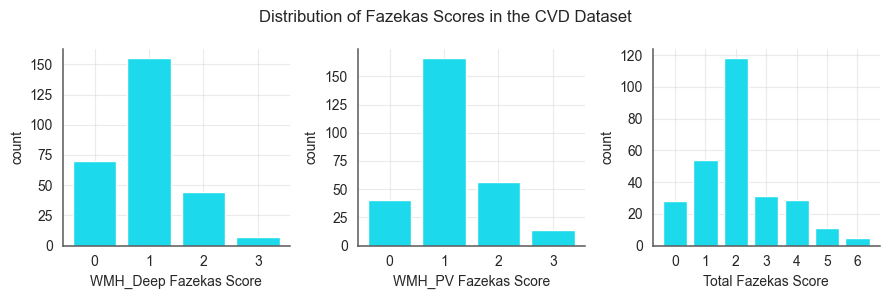

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_hist_bar_plot(axs[0], ADNI_core_df, 'WMH_Deep', 'WMH_Deep Fazekas Score')
simple_hist_bar_plot(axs[1], ADNI_core_df, 'WMH_PV', 'WMH_PV Fazekas Score')
simple_hist_bar_plot(axs[2], ADNI_core_df, 'Total', 'Total Fazekas Score')
plt.suptitle("Distribution of Fazekas Scores in the CVD Dataset")
fig.tight_layout()

### How does predicted WMH volume predict fazekas score?

In [118]:
def simple_box_plot(ax, df, x, y, xlabel=None, ylabel=None, logy=False, logx=False):
    ax = sns.boxplot(data=df, x=x, y=y, ax=ax, hue=x)
    if xlabel == None:
        xlabel = x
    if ylabel == None:
        ylabel = y
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    ax.spines[['left', 'bottom']].set_color('#585858')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')

In [228]:
def simple_scatter_plot(ax, df, x, y, hue=None, xlabel=None, ylabel=None, logy=False, logx=False):
    ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue)
    if xlabel == None:
        xlabel = x
    if ylabel == None:
        ylabel = y
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    ax.spines[['left', 'bottom']].set_color('#585858')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
    print(get_uniques(df, hue))
    plt.legend(loc='lower right', title=hue)
    
    ### adding the pearson correlation coefficient to the plot
    xs = df[x]
    ys = df[y]
    if logx:
        xs = np.log(xs.values)
    if logy:
        ys = np.log(ys.values)
    
    r = scipy.stats.pearsonr(df[x], df[y])[0]
    if r < 0.48:
        xalign = 0.95
        halign="right"
    else:
        xalign=0.05
        halign="left"
    
    # Add text in top right corner
    ax.text(xalign, 0.95, fr'$r={r:.2f}$', 
            verticalalignment='top', 
            horizontalalignment=halign,
            transform=ax.transAxes,
            fontsize=12) 

In [231]:
added_inputs = ["pred", "ent", "ent", "ent", "ent", "pred", "pred", "pred", "pred", "var"]
thresholds = [0.5, 0.1, 0.3, 0.2, 0.45, 0.1, 0.3, 0.5, 0.6, 0.06]
# added_fields = [['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean'], ['kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg'], ['kurtosis']]
added_fields = [pred_values, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields]
added_fields = [f+['ID'] for f in added_fields]

included_terms = [0, 1,2,3,4,5,6, 7, 8]#0]#, 2]#, 1]#, 3]
added_inputs = [added_inputs[idx] for idx in included_terms]
thresholds = [thresholds[idx] for idx in included_terms]
added_fields = [added_fields[idx] for idx in included_terms]

core_fields = ADNI_core_df.keys()

In [232]:
combined_df = merge_datasets(ADNI_core_df[core_fields], added_inputs, thresholds, added_fields)

In [233]:
combined_df['WMH_PV'] = combined_df['WMH_PV'].astype(int)
combined_df['WMH_Deep'] = combined_df['WMH_Deep'].astype(int)

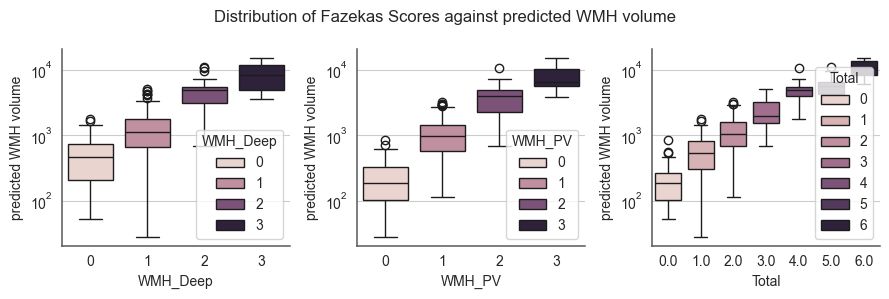

In [234]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_box_plot(axs[0], combined_df, x='WMH_Deep', y='pred0.5_seg_volume', ylabel="predicted WMH volume", logy=True)
simple_box_plot(axs[1], combined_df, x='WMH_PV', y='pred0.5_seg_volume', ylabel="predicted WMH volume", logy=True)
simple_box_plot(axs[2], combined_df, x='Total', y='pred0.5_seg_volume', xlabel='Total', ylabel="predicted WMH volume", logy=True)
plt.suptitle("Distribution of Fazekas Scores against predicted WMH volume")
fig.tight_layout()

### examine how each feature distributes with volume and fazekas category (WMH_PV, WMH_Deep, Total, then GT predicted WMH volume)
dice, lesion f1, avd, sample_div_std, sample_div_IQR, sample_div_skew, and vd equivalents

In [235]:
def quad_fazekas_comparison_plot_box(df, y, ylabel, kind='box', logy=False):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    simple_box_plot(axs[0], df, x='WMH_Deep', y=y, ylabel=ylabel, logy=logy)
    simple_box_plot(axs[1], df, x='WMH_PV', y=y, ylabel=ylabel, logy=logy)
    simple_box_plot(axs[2], df, x='Total', y=y, xlabel='Total', ylabel=ylabel, logy=logy)
    simple_scatter_plot(axs[3], df, x=y, y='pred0.5_seg_volume', hue='WMH_Deep', xlabel=ylabel, ylabel="predicted WMH volume", logy=True, logx=logy)
    if ylabel == None:
        ylabel = y
    plt.suptitle(f"Distribution of {ylabel} across Fazekas Scores")
    fig.tight_layout()

In [236]:
ADNI_core_df.keys()

Index(['Unnamed: 0_x', 'Patient ID', 'AGE', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'WMH_PV', 'WMH_Deep', 'Total',
       'PTGENDER', 'E-M RISK FACTORS', 'DX.bl_0', 'DX.bl_1', 'DX.bl_2',
       'DX.bl_3', 'CV RISK FACTORS_0', 'CV RISK FACTORS_1',
       'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1', 'APOE4_2', 'totatal_fazekas',
       'Unnamed: 0_y', 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew'],
      dtype='object')

[0 1 2 3]


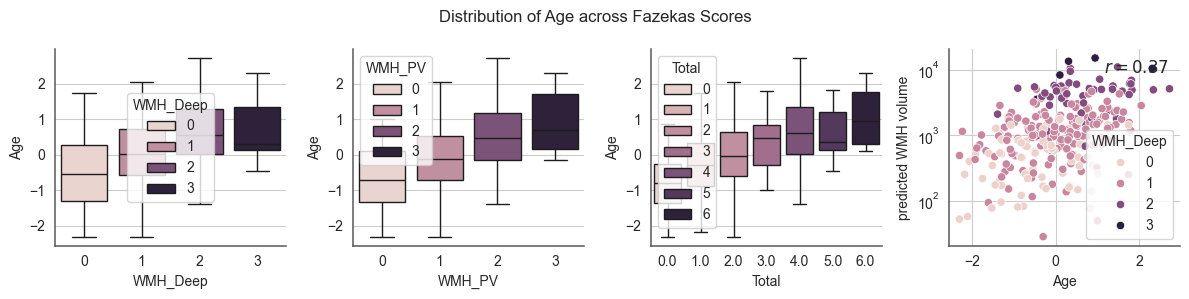

In [237]:
quad_fazekas_comparison_plot_box(combined_df, y='AGE', ylabel='Age')

[0 1 2 3]


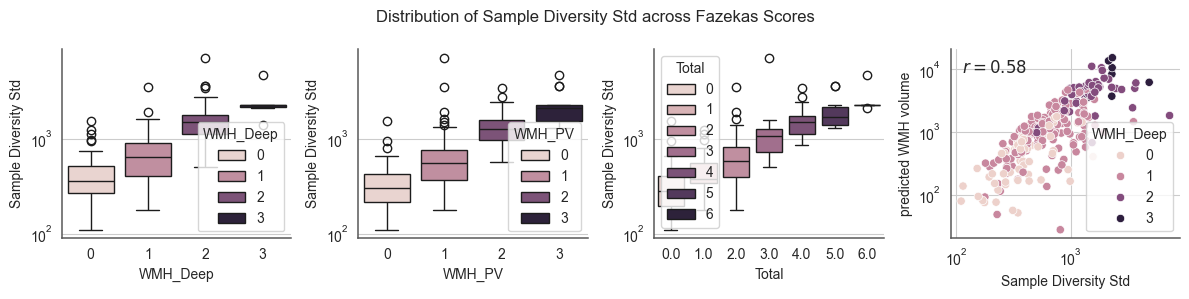

In [238]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_std', ylabel='Sample Diversity Std', kind='box', logy=True)

[0 1 2 3]


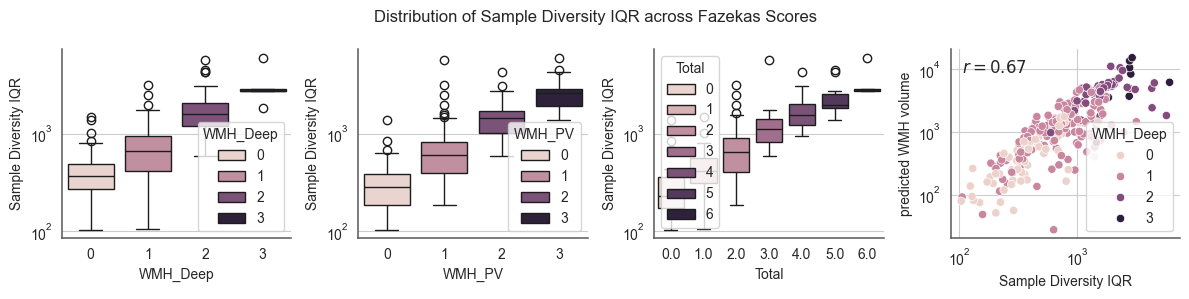

In [239]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_IQR', ylabel='Sample Diversity IQR', kind='box', logy=True)

[0 1 2 3]


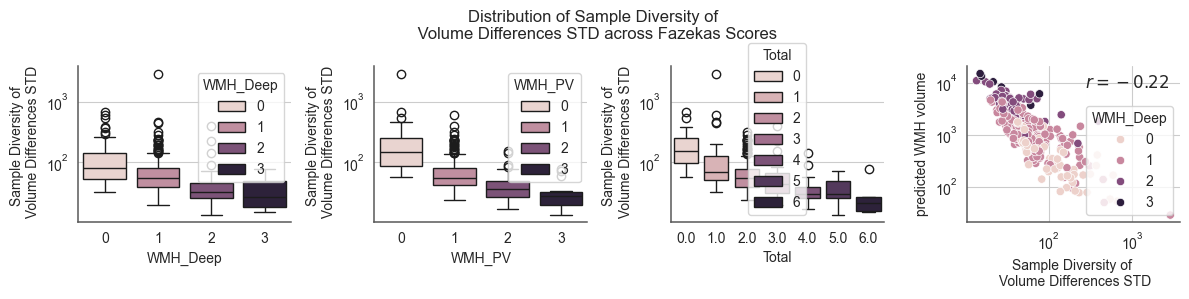

In [240]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_vd_std', ylabel='Sample Diversity of \n Volume Differences STD', kind='box', logy=True)

[0 1 2 3]


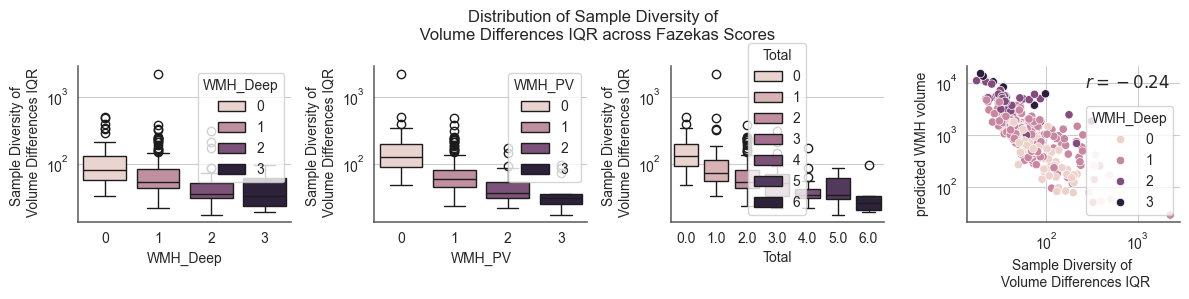

In [241]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_vd_IQR', ylabel='Sample Diversity of \n Volume Differences IQR', kind='box', logy=True)

[0 1 2 3]


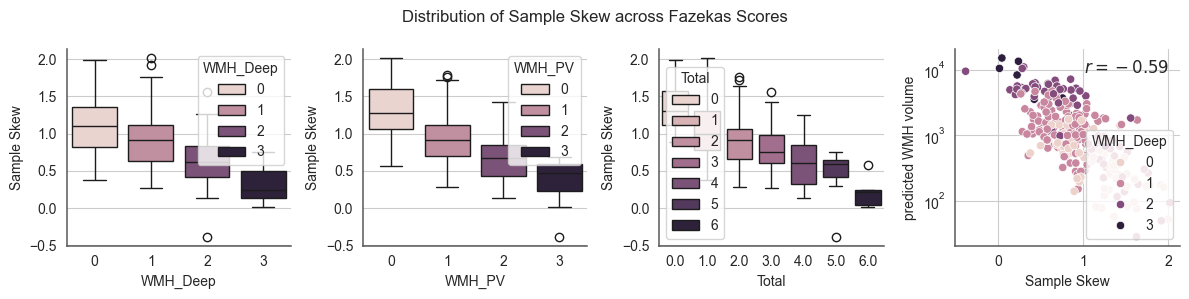

In [242]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_skew', ylabel='Sample Skew', kind='box')

[0 1 2 3]


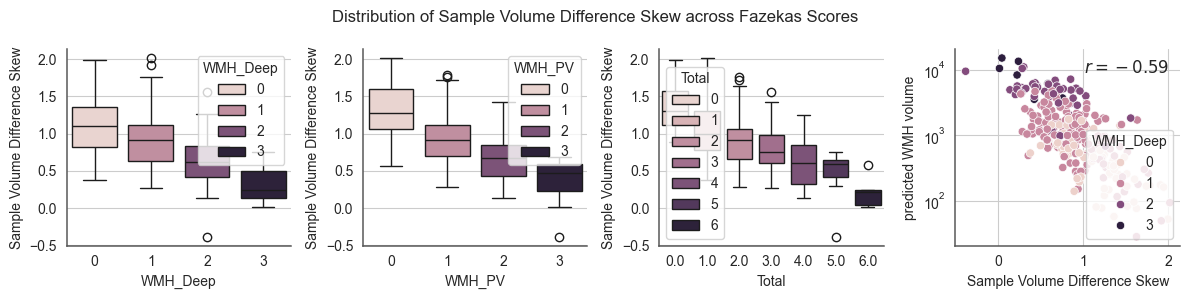

In [195]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_vd_skew', ylabel='Sample Volume Difference Skew', kind='box')

[0 1 2 3]


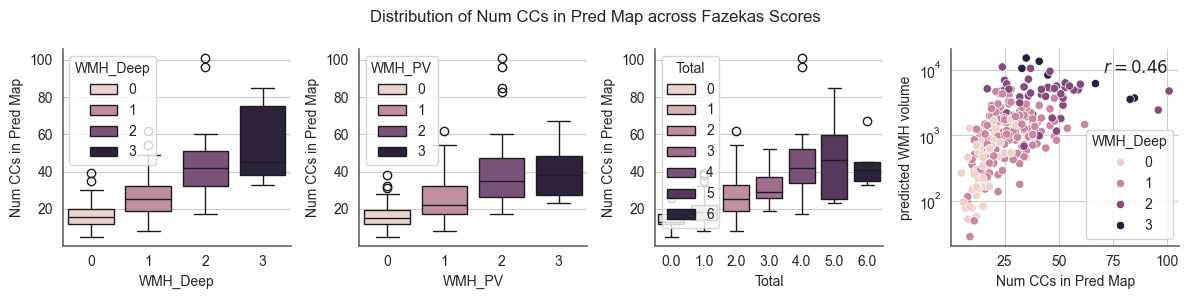

In [205]:
quad_fazekas_comparison_plot_box(combined_df, y='pred0.5_cc_num', ylabel='Num CCs in Pred Map', kind='box')

[0 1 2 3]


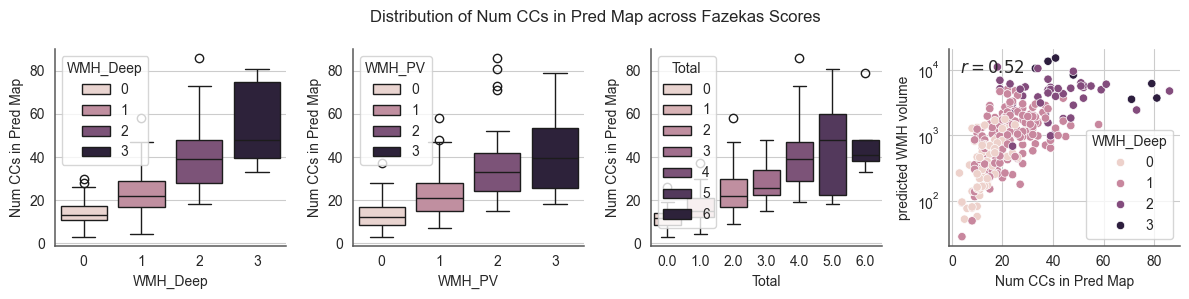

In [206]:
quad_fazekas_comparison_plot_box(combined_df, y='pred0.6_cc_num', ylabel='Num CCs in Pred Map', kind='box')

[0 1 2 3]


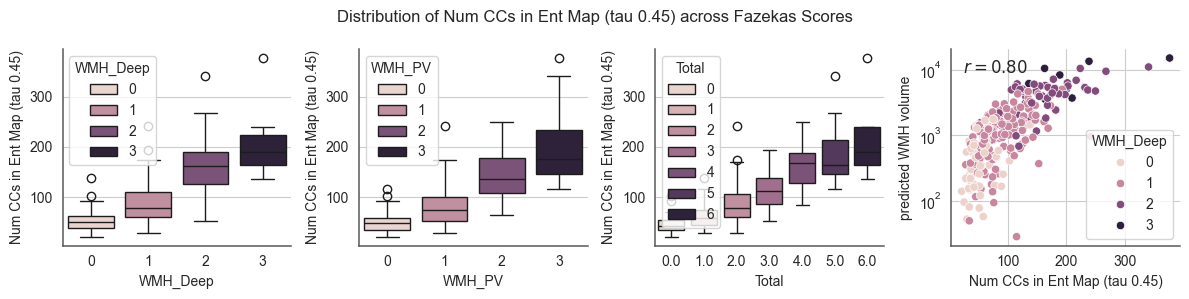

In [207]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_cc_num', ylabel='Num CCs in Ent Map (tau 0.45)', kind='box')

[0 1 2 3]


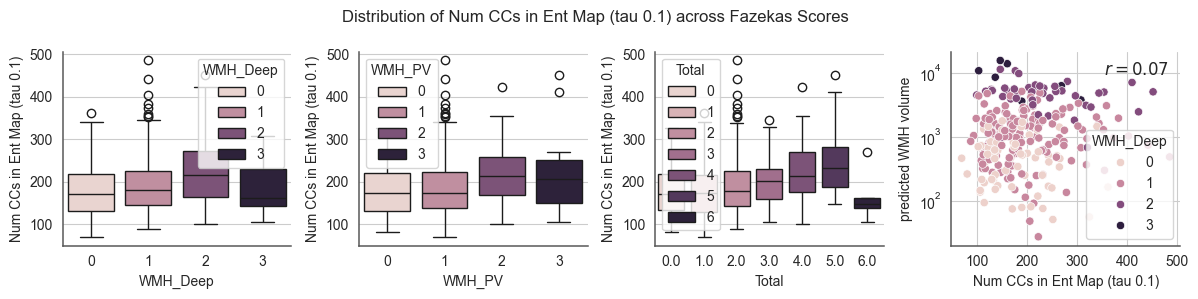

In [208]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_cc_num', ylabel='Num CCs in Ent Map (tau 0.1)', kind='box')

[0 1 2 3]


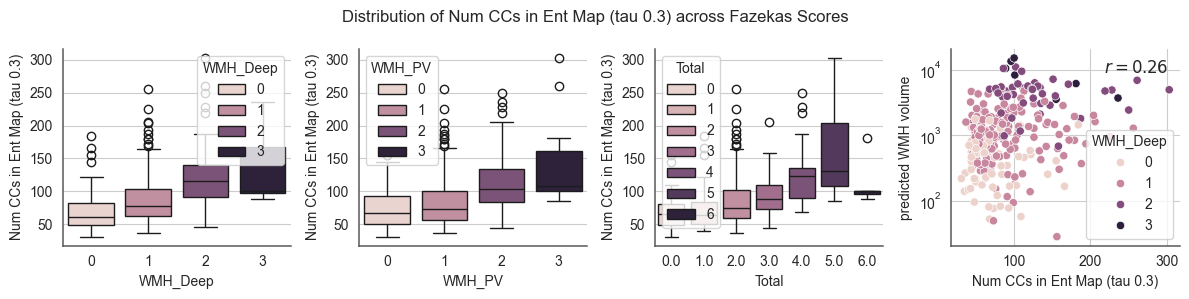

In [209]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.3_cc_num', ylabel='Num CCs in Ent Map (tau 0.3)', kind='box')

[0 1 2 3]


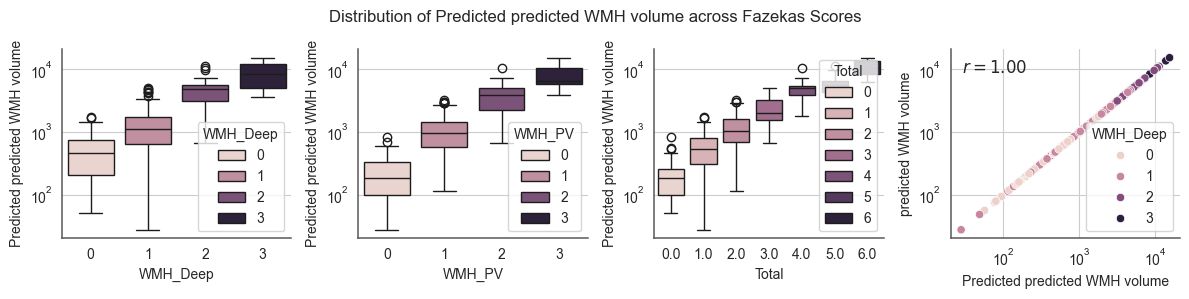

In [210]:
quad_fazekas_comparison_plot_box(combined_df, y='pred0.5_seg_volume', ylabel='Predicted predicted WMH volume', kind='box', logy=True)

[0 1 2 3]


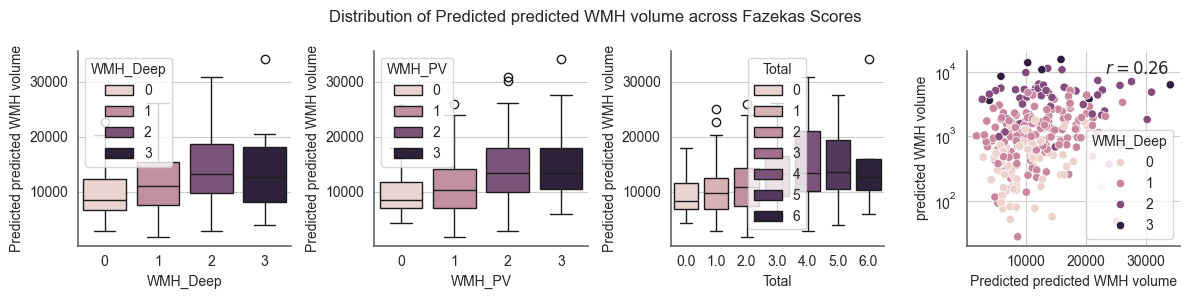

In [211]:
quad_fazekas_comparison_plot_box(combined_df, y='pred0.5_vent_volume', ylabel='Predicted predicted WMH volume', kind='box', logy=False)

[0 1 2 3]


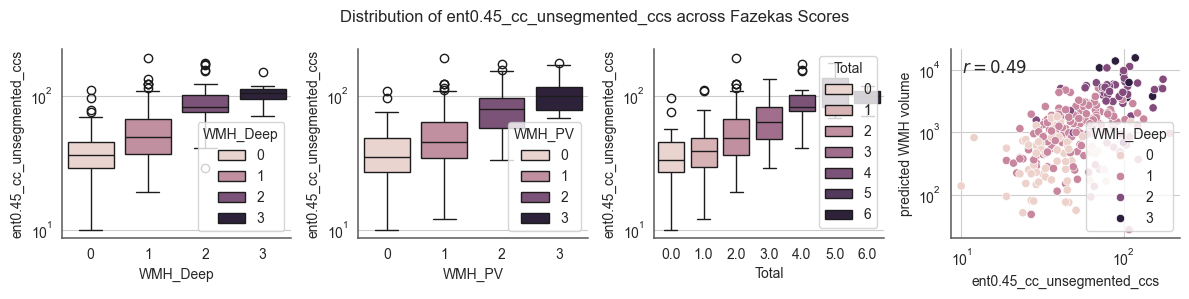

In [214]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_cc_unsegmented_ccs', ylabel=None, kind='box', logy=True)

[0 1 2 3]


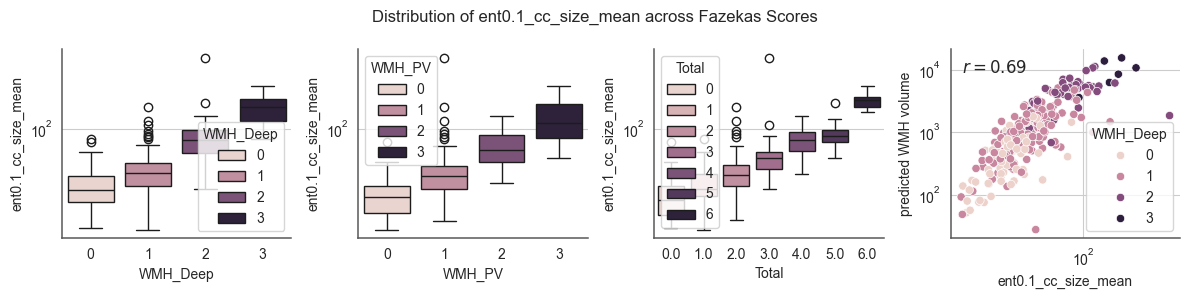

In [215]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_cc_size_mean', ylabel=None, kind='box', logy=True)

[0 1 2 3]


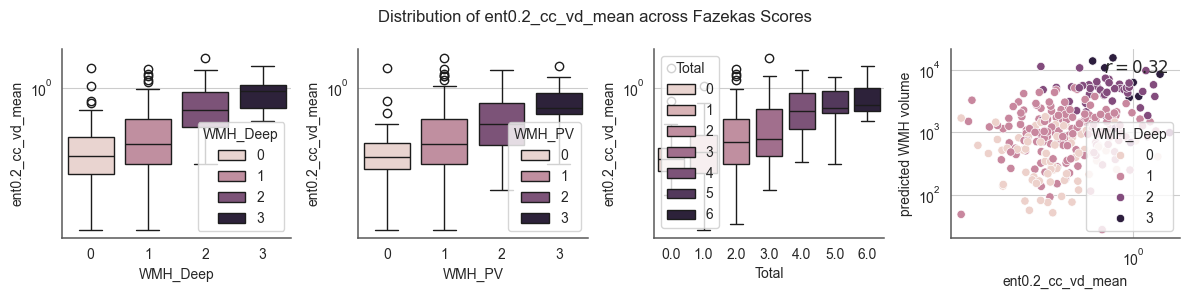

In [216]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.2_cc_vd_mean', ylabel=None, kind='box', logy=True)

[0 1 2 3]


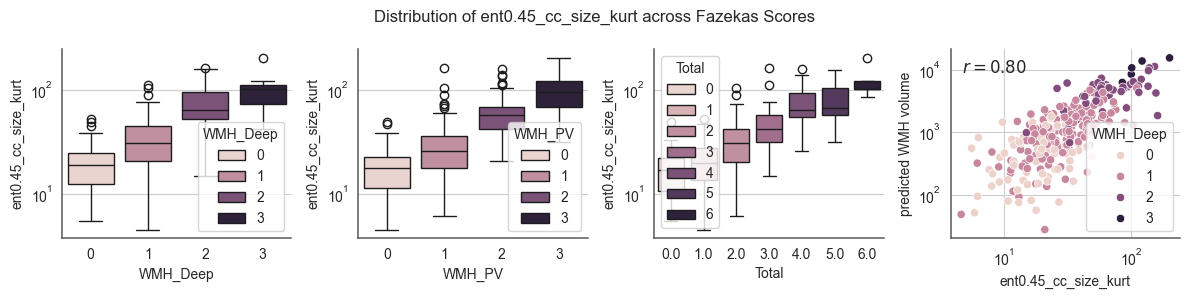

In [217]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_cc_size_kurt', ylabel=None, kind='box', logy=True)

[0 1 2 3]


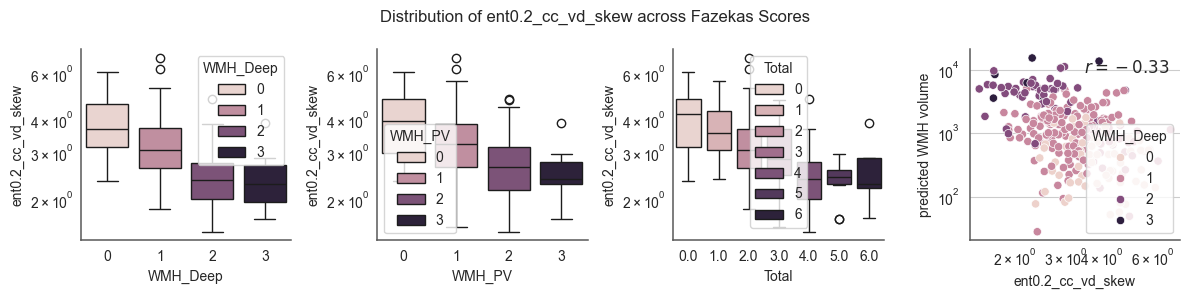

In [218]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.2_cc_vd_skew', ylabel=None, kind='box', logy=True)

[0 1 2 3]


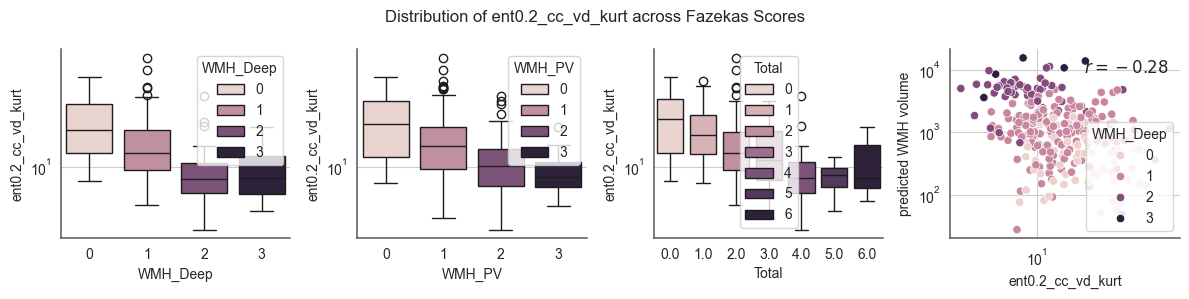

In [219]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.2_cc_vd_kurt', ylabel=None, kind='box', logy=True)

[0 1 2 3]


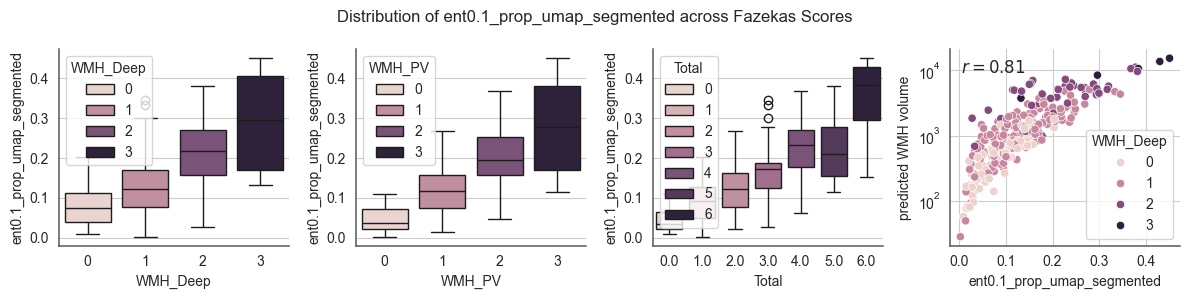

In [220]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_prop_umap_segmented', ylabel=None, kind='box', logy=False)

[0 1 2 3]


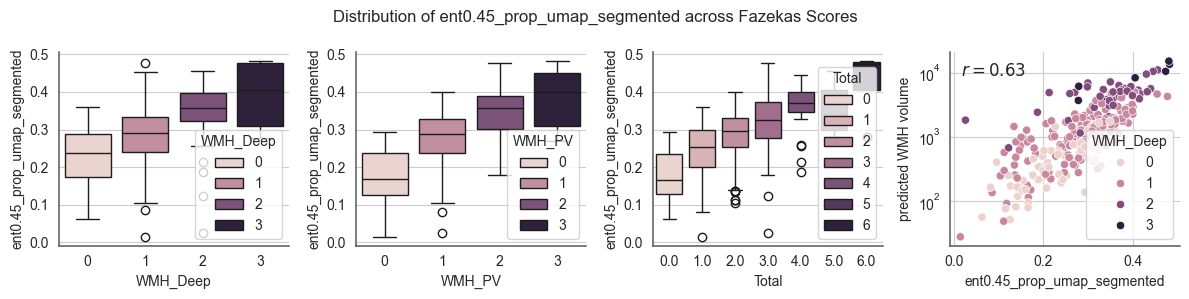

In [221]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_prop_umap_segmented', ylabel=None, kind='box', logy=False)

[0 1 2 3]


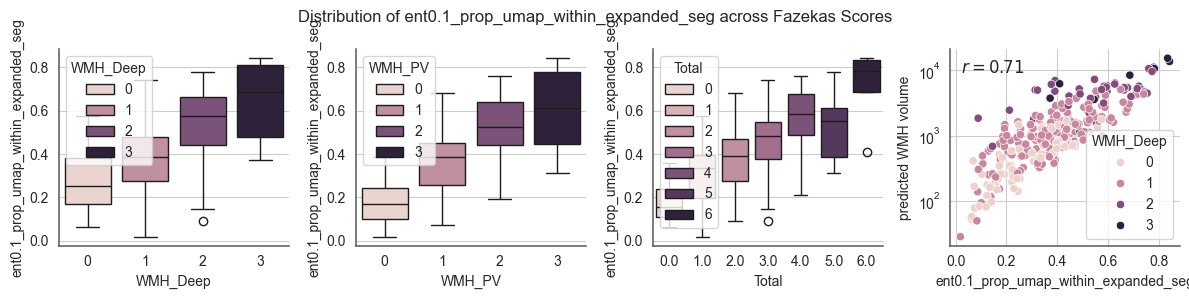

In [222]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_prop_umap_within_expanded_seg', ylabel=None, kind='box', logy=False)

[0 1 2 3]


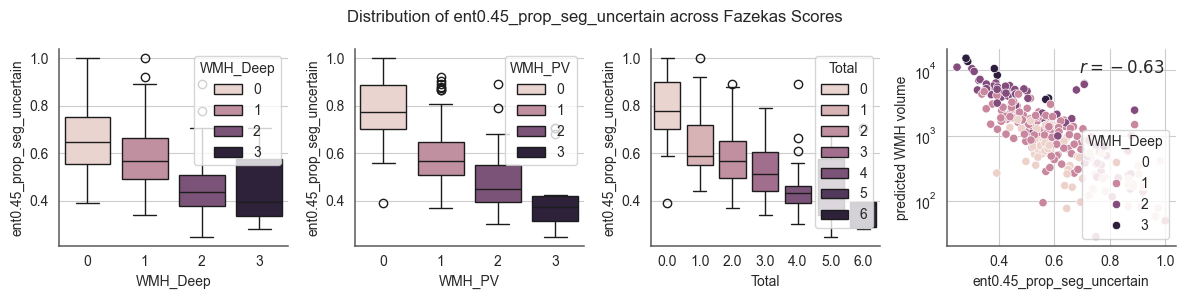

In [223]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_prop_seg_uncertain', ylabel=None, kind='box', logy=False)

[0 1 2 3]


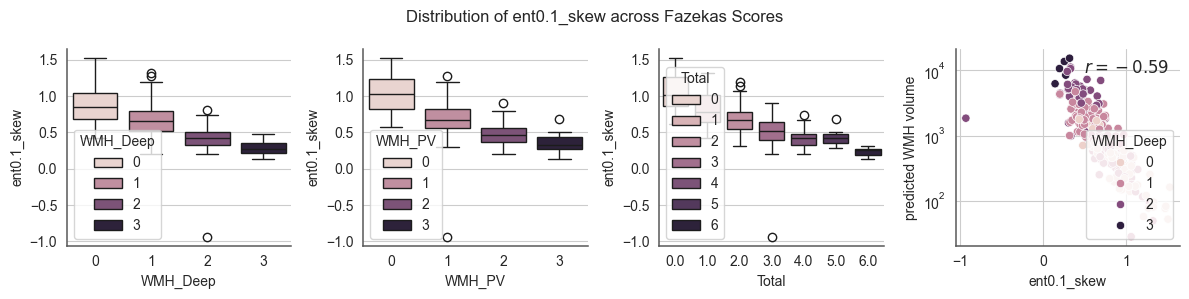

In [224]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_skew', ylabel=None, kind='box', logy=False)

[0 1 2 3]


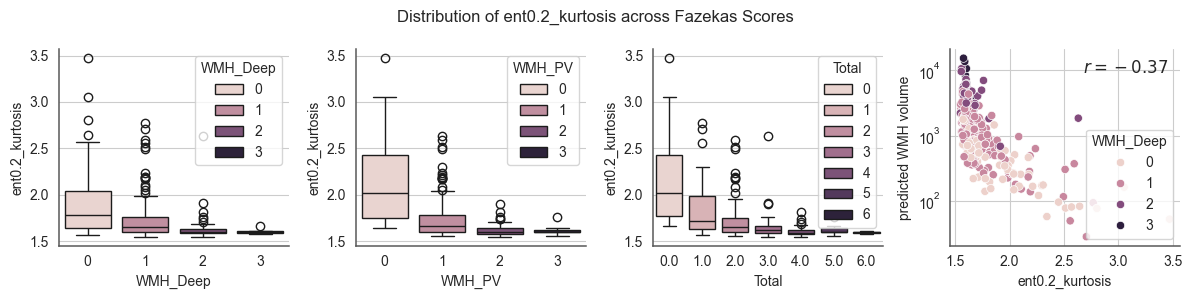

In [225]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.2_kurtosis', ylabel=None, kind='box')